## Рекомендательная система

### Этап 1. Подготовка данных

In [25]:
# эти библиотеки нам уже знакомы
import pandas as pd
import numpy as np

# модуль sparse библиотеки scipy понадобится
# для работы с разреженными матрицами (об этом ниже)
from scipy.sparse import csr_matrix

# из sklearn мы импортируем алгоритм k-ближайших соседей
from sklearn.neighbors import NearestNeighbors

Для начала прочитаем внешние файлы

In [26]:
# прочитаем внешние файлы (перед этим их необходимо импортировать) и преобразуем в датафрейм
movies = pd.read_csv('anime.csv')
ratings = pd.read_csv('rating.csv')

In [27]:
# посмотрим на содержимое файла movies.csv
# дополнительно удалим столбец genres, он нам не нужен
# (параметр axis = 1 говорит, что мы работаем со столбцами, inplace = True, что изменения нужно сохранить)
movies.drop(['genre', 'type', 'episodes', 'members', 'rating'], axis = 1, inplace = True)
movies.head(3)

,anime_id,name
0,32281,Kimi no Na wa.
1,5114,Fullmetal Alchemist: Brotherhood
2,28977,Gintama°


In [28]:
# и ratings.csv (здесь также удаляем ненужный столбец timestamp)
# ratings.drop(['timestamp'], axis = 1, inplace = True)
ratings.head(3)

,user_id,anime_id,rating_a
0,1,20,-1
1,1,24,-1
2,1,79,-1


In [29]:
# для этого воспользуемся функцией pivot и создадим сводную таблицу (pivot table)
# по горизонтали будут фильмы, по вертикали - пользователи, значения - оценки
user_item_matrix = ratings.pivot(index = 'anime_id', columns = 'user_id', values= 'rating_a')
user_item_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,10084,10085,10086,10087,10088,10089,10090,10091,10092,10093
anime_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,-1.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# пропуски NaN нужно преобразовать в нули
# параметр inplace = True опять же поможет сохранить результат
user_item_matrix.fillna(0, inplace = True)
user_item_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,10084,10085,10086,10087,10088,10089,10090,10091,10092,10093
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,-1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# посмотрим на размерность матрицы "пользователи х фильмы"
user_item_matrix.shape

(8347, 10093)

Теперь давайте уберем неактивных пользователей и фильмы с небольшим количеством оценок

In [33]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = ratings.groupby('user_id')['rating_a'].agg('count')

# сделаем то же самое, только для фильма
movies_votes = ratings.groupby('anime_id')['rating_a'].agg('count')

In [34]:
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 50].index
movie_mask = movies_votes[movies_votes > 10].index

In [35]:
# применим фильтры и отберем фильмы с достаточным количеством оценок
user_item_matrix = user_item_matrix.loc[movie_mask,:]

# а также активных пользователей
user_item_matrix = user_item_matrix.loc[:,user_mask]

In [36]:
# посмотрим сколько пользователей и фильмов осталось
user_item_matrix.shape

(4924, 5317)

Мы почти завершили первый этап. В частности, осталось преобразовать нашу разреженную матрицу (sparce matrix) в сжатое хранение строкой (сompressed sparse row) с помощью функции csr_matrix библиотеки Scipy.

In [37]:
# преобразуем разреженную матрицу в формат csr
# метод values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(user_item_matrix.values)

# посмотрим на первые записи
# сопоставьте эти значения с исходной таблицей выше
print(csr_data[:2,:5])

In [38]:
# остается только сбросить индекс с помощью reset_index()
# это необходимо для удобства поиска фильма по индексу
user_item_matrix = user_item_matrix.rename_axis(None, axis = 1).reset_index()
user_item_matrix.head()

,anime_id,1,3,4,5,7,11,13,14,17,...,10076,10080,10082,10083,10086,10087,10088,10089,10092,10093
0,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,-1.0,8.0,0.0,0.0,-1.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Этап 2. Обучение модели

In [39]:
# воспользуемся классом NearestNeighbors для поиска расстояний
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)

# обучим модель
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

### Этап 3. Составление рекомендаций

Зададим изначальные параметры поиска

In [40]:
# ждя начала определимся, сколько рекомендаций мы хотим получить
recommendations = 10

# и на основе какого фильма
search_word = 'Slam Dunk'

Найдем индекс фильма в матрице предпочтений

In [41]:
# для начала найдем фильм в заголовках датафрейма movies
movie_search = movies[movies['name'].str.contains(search_word)]
movie_search

,anime_id,name
79,170,Slam Dunk
903,2499,Slam Dunk: Hoero Basketman-damashii! Hanamichi...
1094,2498,Slam Dunk: Shouhoku Saidai no Kiki! Moero Saku...
1149,1861,Slam Dunk: Zenkoku Seiha Da! Sakuragi Hanamichi
1686,1764,Slam Dunk (Movie)


In [42]:
# вариантов может быть несколько, для простоты всегда будем брать первый вариант
# через iloc[0] мы берем первую строку столбца ['movieId']
movie_id = movie_search.iloc[0]['anime_id']

# далее по индексу фильма в датасете movies найдем соответствующий индекс
# в матрице предпочтений
movie_id = user_item_matrix[user_item_matrix['anime_id'] == movie_id].index[0]
movie_id

146

Находим схожие фильмы

In [43]:
# теперь нужно найти индексы и расстояния фильмов, которые похожи на наш запрос
# воспользуемся методом kneighbors()
distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors = recommendations + 1)

In [44]:
# индексы рекомендованных фильмов
indices

array([[ 146, 1391, 1792, 1791,  230, 1449,  113, 2507,  556, 2058,    7]],
      dtype=int64)

In [45]:
# расстояния до них
distances

array([[0.        , 0.62961677, 0.6542593 , 0.66191549, 0.66712796,
        0.66751144, 0.66758681, 0.68539348, 0.69996336, 0.70391075,
        0.70464876]])

In [46]:
# уберем лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()

# далее с помощью функций zip и list преобразуем наши списки
indices_distances = list(zip(indices_list, distances_list))

# в набор кортежей (tuple)
print(type(indices_distances[0]))

# и посмотрим на первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(146, 0.0), (1391, 0.6296167654379177), (1792, 0.6542592991078453)]


In [47]:
# остается отсортировать список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

# и убрать первый элемент с индексом 901 (потому что это и есть "Матрица")
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(1391, 0.6296167654379177),
 (1792, 0.6542592991078453),
 (1791, 0.6619154898229549),
 (230, 0.6671279565191843),
 (1449, 0.6675114391943233),
 (113, 0.6675868132734761),
 (2507, 0.685393481561889),
 (556, 0.6999633639842118),
 (2058, 0.7039107514840802),
 (7, 0.704648764625273)]

Остается найти какие фильмы соответствуют найденным нами индексам

In [48]:
# создаем пустой список, в который будем помещать название фильма и расстояние до него
recom_list = []

# теперь в цикле будем поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:

    # искать movieId в матрице предпочтений
    matrix_movie_id = user_item_matrix.iloc[ind_dist[0]]['anime_id']

    # выяснять индекс этого фильма в датафрейме movies
    id = movies[movies['anime_id'] == matrix_movie_id].index

    # брать название фильма и расстояние до него
    title = movies.iloc[id]['name'].values[0]
    dist = ind_dist[1]

    # помещать каждую пару в питоновский словарь
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Name' : title, 'Distance' : dist})

In [49]:
# посмотрим на первый элемент
recom_list[0]

{'Name': 'Slam Dunk (Movie)', 'Distance': 0.6296167654379177}

In [50]:
# остается преобразовать наш список в датафрейм
# индекс будем начинать с 1, как и положено рейтингу
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Name,Distance
1,Slam Dunk (Movie),0.629617
2,Slam Dunk: Hoero Basketman-damashii! Hanamichi...,0.654259
3,Slam Dunk: Shouhoku Saidai no Kiki! Moero Saku...,0.661915
4,Hajime no Ippo,0.667128
5,Slam Dunk: Zenkoku Seiha Da! Sakuragi Hanamichi,0.667511
6,Hunter x Hunter,0.667587
7,Hajime no Ippo: New Challenger,0.685393
8,Major S1,0.699963
9,Major S4,0.703911
10,Hungry Heart: Wild Striker,0.704649


### Ответы на вопросы

**Вопрос**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Векторы на графике

In [ ]:
# создадим два вектора с координатами [10, 10] и [1, 1]
x = np.array([10, 10])
y = np.array([1, 1])

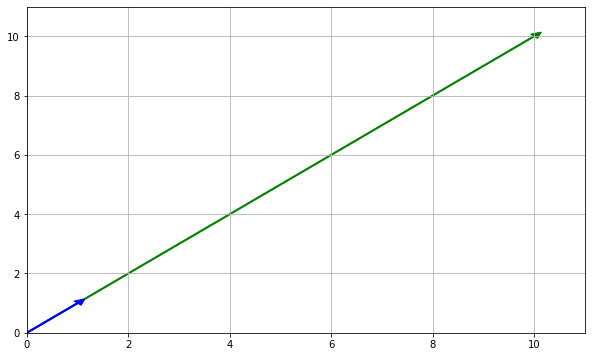

In [ ]:
# зададим размер фигуры (контейнера, в который помещаются графики)
plt.figure(figsize = (10, 6))

# создадим объект графика внутри этой фигуры
ax = plt.axes()

# зададим диапазон осей x и y
plt.xlim([0, 11])
plt.ylim([0, 11])
plt.grid()

# нашими "подграфиками" будут два вектора в форме стрелок
ax.arrow(0, 0, x[0], x[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'g', ec = 'g')
ax.arrow(0, 0, y[0], y[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'b', ec = 'b')

plt.show()

Расчет косинусного сходства

In [ ]:
# напишем функцию для расчета косинусного сходства
def similar(x, y):

    # рассчитаем длины векторов
    xLen = np.linalg.norm(x)
    yLen = np.linalg.norm(y)

    # подставим их в формулу косинусного сходства
    result = np.dot(x, y)/(xLen * yLen)

    # выведем результат
    return result

In [ ]:
# ожидаемо косунус угла будет равен единице
round(similar(x, y), 3)

1.0

Item-based система

In [ ]:
# создадим массив Numpy с оценками
films = np.array(
    [
     [1, 3, 2, 6, 2, 1, 0],
     [0, 2, 0, 3, 0, 6, 2],
     [1, 1, 1, 1, 1, 1, 1],
     [2, 4, 1, 3, 9, 2, 1],
     [10, 10, 10, 10, 10, 10, 10]
     ]
)

# строки это фильмы, столбцы - пользователи
films

array([[ 1,  3,  2,  6,  2,  1,  0],
       [ 0,  2,  0,  3,  0,  6,  2],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 2,  4,  1,  3,  9,  2,  1],
       [10, 10, 10, 10, 10, 10, 10]])

In [ ]:
# предположим, вышел новый фильм, и все пользователи поставили ему рейтинг 10
new_film = np.array([10, 10, 10, 10, 10, 10, 10])

In [ ]:
# в цикле for поочередно рассчитаем косинусное сходство каждого из имеющхся фильмов с новым фильмом
for i, film in enumerate(films, 1):
  print(f'Фильм {i} с оценками {film} имеет сходство с новым фильмом {np.round(similar(film, new_film), 3)}')

Фильм 1 с оценками [1 3 2 6 2 1 0] имеет сходство с новым фильмом 0.764
Фильм 2 с оценками [0 2 0 3 0 6 2] имеет сходство с новым фильмом 0.675
Фильм 3 с оценками [1 1 1 1 1 1 1] имеет сходство с новым фильмом 1.0
Фильм 4 с оценками [2 4 1 3 9 2 1] имеет сходство с новым фильмом 0.772
Фильм 5 с оценками [10 10 10 10 10 10 10] имеет сходство с новым фильмом 1.0
